In [1]:
import cv2
import numpy as np
import os
from google.colab import drive
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1
The images were first loaded and aggregated into a single dataset. This dataset was subsequently split into training and testing sets. Dimensionality reduction was performed by projecting the data onto the space defined by the first 50 principal components extracted from the training set.

In [2]:
def load_images(path):
    os.chdir(path)
    images = []
    for f in os.listdir():
        img = cv2.imread(f)
        images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    return np.array(images).reshape(len(images), -1)

base_dir = '/content/drive/My Drive/Colab Notebooks/VisionLab/Cohn-Kanade/images/'
x_h = load_images(base_dir + 'happy')
x_s = load_images(base_dir + 'surprise')

In [3]:
X_train_h, X_test_h = train_test_split(x_h, train_size=50, random_state=42)
X_train_s, X_test_s = train_test_split(x_s, train_size=50, random_state=42)

In [4]:
from sklearn.decomposition import PCA

X_train = np.concatenate((X_train_h, X_train_s), axis=0)
X_test = np.concatenate((X_test_h, X_test_s), axis=0)

n_h = X_train_h.shape[0]
n_s = X_train_s.shape[0]

y_train = np.array([0]*n_h + [1]*n_s)
y_test = np.array([0]*X_test_h.shape[0] + [1]*X_test_s.shape[0])

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train.shape, X_test.shape)

(100, 180000) (73, 180000)


In [5]:
X_train_pca_h = X_train_pca[:n_h]
X_train_pca_s = X_train_pca[n_h:]

mean_h = np.mean(X_train_pca_h, axis=0)
mean_s = np.mean(X_train_pca_s, axis=0)
mean = np.mean(X_train_pca)

cov_h = np.cov(X_train_pca_h, rowvar=False)
cov_s = np.cov(X_train_pca_s, rowvar=False)
cov = np.cov(X_train_pca, rowvar=False)

Using the formulas provided in the instructions, the Within-Class Scatter Matrix ($S_W$) and the Between-Class Scatter Matrix ($S_B$) are computed. Subsequently, the Fisher Eigenvector is determined by solving the generalized eigenvalue problem ($S_W^{-1} S_B$)

In [6]:
S_W = (n_h - 1) * cov_h + (n_s - 1) * cov_s

scatter_h = n_h * np.outer(mean_h - mean, mean_h - mean)
scatter_s = n_s * np.outer(mean_s - mean, mean_s - mean)
S_B = scatter_h + scatter_s

In [7]:
A = np.linalg.inv(S_W) @ S_B
eigenvalues, eigenvectors = np.linalg.eig(A)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print(f"Number of nonzero eigenvalues: {np.count_nonzero(eigenvalues)}")

Number of nonzero eigenvalues: 50


The resulting Fisher Eigenvector is then displayed. The image plane reveals dark regions and light regions which, respectively, correspond to areas in the feature space most strongly associated with the `happy` and `surprise` image classes.

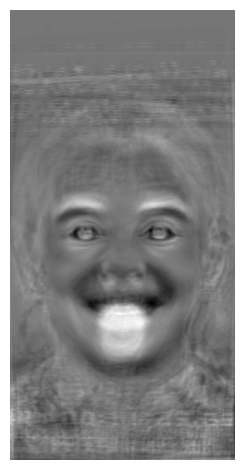

In [8]:
import matplotlib.pyplot as plt

w = 300
h = 600

pca_components = pca.components_
fisher_component = pca_components.T @ eigenvectors[:, 0]

plt.imshow(fisher_component.reshape(h, w), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
import numpy as np

class LDA:

    def __init__(self):
        self.threshold = None
        self.mean_class1_is_larger = None
        self.fisher_eigenvector = None

    def fit(self, X_train, y_train):

        X0 = X_train[y_train == 0]
        X1 = X_train[y_train == 1]

        mu0 = np.mean(X0, axis=0)
        mu1 = np.mean(X1, axis=0)

        # Calculate S_W (Within-Class Scatter Matrix)
        SW = np.zeros((X_train.shape[1], X_train.shape[1]))

        for Xc, muc in [(X0, mu0), (X1, mu1)]:
            centered_data = Xc - muc
            Sc = centered_data.T @ centered_data
            SW += Sc

        # Solve for Fisher Eigenvector w: w is proportional to S_W^{-1} * (mu1 - mu0)
        SW_inv = np.linalg.inv(SW)
        mean_diff = mu1 - mu0
        w = SW_inv @ mean_diff

        # Store normalized eigenvector
        self.fisher_eigenvector = w / np.linalg.norm(w)

        # Project X_train onto the 1D line defined by w
        X_train_proj = X_train @ self.fisher_eigenvector

        # Determine Classification Threshold
        proj_class0 = X_train_proj[y_train == 0]
        proj_class1 = X_train_proj[y_train == 1]

        mean_proj_class0 = np.mean(proj_class0)
        mean_proj_class1 = np.mean(proj_class1)

        self.threshold = (mean_proj_class0 + mean_proj_class1) / 2
        self.mean_class1_is_larger = mean_proj_class1 > mean_proj_class0

        # Predict and Evaluate Training Error
        if self.mean_class1_is_larger:
            y_pred = (X_train_proj > self.threshold).astype(int)
        else:
            y_pred = (X_train_proj < self.threshold).astype(int)

        error_rate = np.sum(y_pred != y_train) / len(y_train)

        return y_pred, error_rate

    def predict(self, X_test):
        if self.fisher_eigenvector is None:
            raise Exception("Model must be fit before prediction.")

        # Project the test data using the trained eigenvector
        X_test_proj = X_test @ self.fisher_eigenvector

        # Classify using the trained threshold
        if self.mean_class1_is_larger:
            y_pred = (X_test_proj > self.threshold).astype(int)
        else:
            y_pred = (X_test_proj < self.threshold).astype(int)

        return y_pred

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        test_error = np.sum(y_pred != y_test) / len(y_test)
        return y_pred, test_error

Finally, we performed the Fisher classification (LDA) on both the training and testing datasets. The classification errors were then directly compared against the results obtained from K-Nearest Neighbors (KNN) classification for three different neighborhood sizes: $k = 1$, $k = 3$, and $k = 5$.

As demonstrated by the results, the LDA method yields superior classification performance when a lower number of principal components are retained, relative to the competing methods tested.

5 - 10 - 15 - 20 - 25 - 30 - 35 - 40 - 45 - 

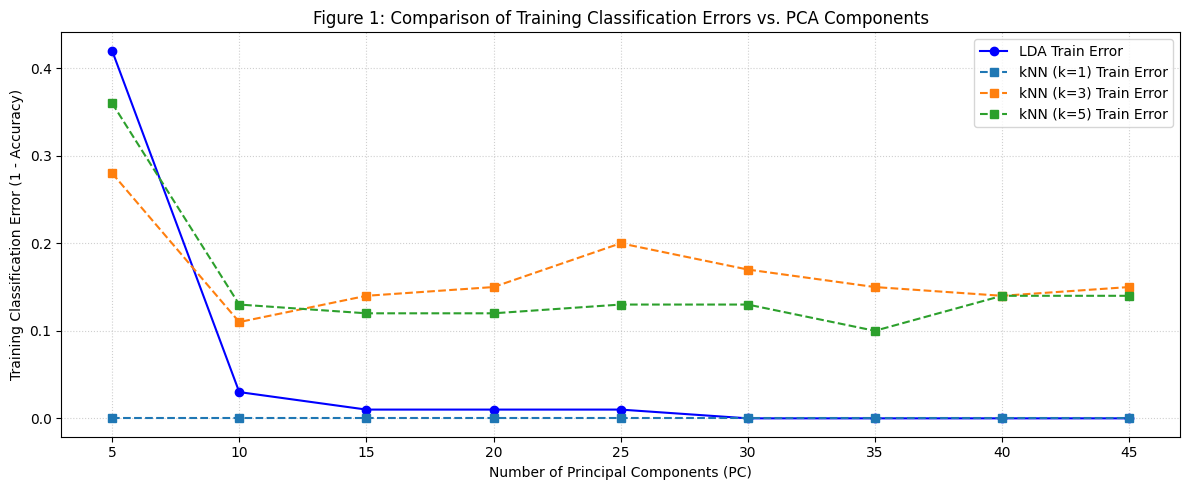

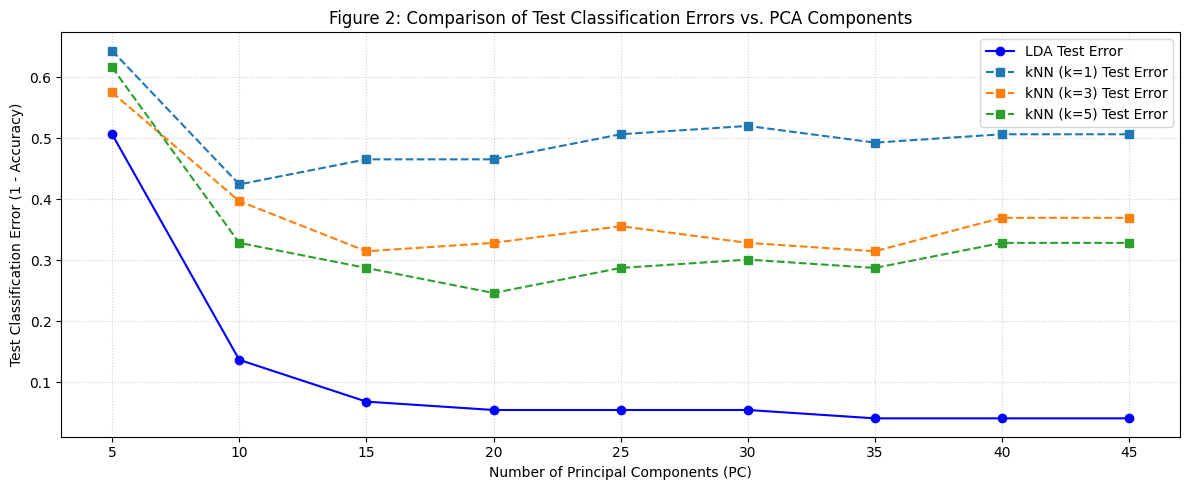

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

PC_RANGE = range(5, 50, 5)
K_VALUES = [1, 3, 5]

pca_train_errors = []
pca_test_errors = []

knn_train_errors_by_k = {k: [] for k in K_VALUES}
knn_test_errors_by_k = {k: [] for k in K_VALUES}


for n_comp in PC_RANGE:
    print(n_comp, end=' - ')
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    lda_model = LDA()
    lda_model.fit(X_train_pca, y_train)

    _, lda_train_error = lda_model.evaluate(X_train_pca, y_train)
    _, lda_test_error = lda_model.evaluate(X_test_pca, y_test)

    pca_train_errors.append(lda_train_error)
    pca_test_errors.append(lda_test_error)

    for k in K_VALUES:
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(X_train_pca, y_train)

        y_train_pred_knn = knn_model.predict(X_train_pca)
        y_test_pred_knn = knn_model.predict(X_test_pca)

        knn_train_errors_by_k[k].append(1 - accuracy_score(y_train, y_train_pred_knn))
        knn_test_errors_by_k[k].append(1 - accuracy_score(y_test, y_test_pred_knn))


# --- Figure 1: Training Errors ---
plt.figure(figsize=(12, 5))
plt.plot(PC_RANGE, pca_train_errors, marker='o', linestyle='-', label='LDA Train Error', color='blue')
for k in K_VALUES:
    plt.plot(PC_RANGE, knn_train_errors_by_k[k], marker='s', linestyle='--', label=f'kNN (k={k}) Train Error')

plt.title('Figure 1: Comparison of Training Classification Errors vs. PCA Components')
plt.xlabel('Number of Principal Components (PC)')
plt.ylabel('Training Classification Error (1 - Accuracy)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(np.arange(min(PC_RANGE), max(PC_RANGE)+1, 5))
plt.tight_layout()
plt.show()

# --- Figure 2: Test Errors ---
plt.figure(figsize=(12, 5))
plt.plot(PC_RANGE, pca_test_errors, marker='o', linestyle='-', label='LDA Test Error', color='blue')
for k in K_VALUES:
    plt.plot(PC_RANGE, knn_test_errors_by_k[k], marker='s', linestyle='--', label=f'kNN (k={k}) Test Error')

plt.title('Figure 2: Comparison of Test Classification Errors vs. PCA Components')
plt.xlabel('Number of Principal Components (PC)')
plt.ylabel('Test Classification Error (1 - Accuracy)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(np.arange(min(PC_RANGE), max(PC_RANGE)+1, 5))
plt.tight_layout()
plt.show()